In [75]:
from scipy.io import loadmat
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.losses import Loss
from calibration_stats import ExpectedCalibrationError
import time 
from matplotlib import pyplot as plt
from helper import load_dataset_sev


(26032, 32, 32, 3)
(26032, 1)
(73257, 32, 32, 3)
(26032, 32, 32)
[1]


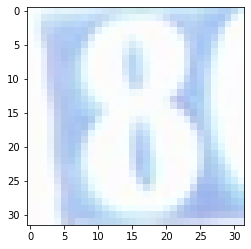

In [7]:
train_raw = loadmat('/home/thlarsen/ood_detection/learn_uncertainty/datasets/svhndataset/train_32x32.mat')
test_raw = loadmat('/home/thlarsen/ood_detection/learn_uncertainty/datasets/svhndataset/test_32x32.mat')


N=200

x_train_raw = np.array(train_raw['X'])
x_test_raw = np.array(test_raw['X'])

x_train_raw = np.moveaxis(x_train_raw, -1, 0)
x_test_raw = np.moveaxis(x_test_raw, -1, 0)

y_train = train_raw['y']
y_test = test_raw['y']

print(x_test_raw.shape)
print(y_test.shape)


print(x_train_raw.shape)
plt.imshow(x_train_raw[4003])

def process_images(x): 
    x = np.dot(x, [0.299, 0.587, 0.114])
    print(x.shape)
#     for i in range(30, 40):
#         print(f'i={i}, y={y_test[i]}, mean={np.mean(x[i])}')
#         print(x[i])
#         plt.imshow(x[i])
#         plt.show()

    x = np.reshape(x, (-1, 32*32))
    return x.astype('float64')


# x_train = process_images(x_train)
x_test = process_images(x_test_raw)
# y_train = y_train.astype('int64')
y_test = y_test.astype('int64')
print(y_test[35])

In [16]:
input_dim = 32*32
(x_train_m, y_train_m), (x_test_m, y_test_m) = keras.datasets.mnist.load_data()

x_train_m = np.pad(x_train_m, ((0,0),(2,2),(2,2)), 'constant')
x_test_raw_m = np.pad(x_test_m, ((0,0),(2,2),(2,2)), 'constant')

In [ ]:
indxs = [1, 2, 3, 4, 5]


fig, axes = plt.subplots(nrows=1, ncols=len(indxs), figsize=(28, 28))
fig.tight_layout(pad=3.0)

for i, x in enumerate(indxs): 
#     data_s, labels_s = data_by_sev[sev]    
#     print(f'label={labels[i]}, sev={sev[i]}')
    axes[i].imshow(x_train_m[x], cmap='gray')
#     axes[x].title.set_text(f'sev={sev}')
#     axes[x].set_title(f'sev={sev}', fontdict={'fontsize': 15, 'fontweight': 'medium'})
#     axes[x].set_fontsize(20)

#     x+=1
plt.show()

In [ ]:
e

In [60]:
lr = 10**-3 
w = 1
prefix = '/home/thlarsen/ood_detection/learn_uncertainty/'
model_save_path = f'{prefix}saved_weights/mnist_calibrate/cal(lr={lr})(w={w})'

model = keras.models.load_model(model_save_path)

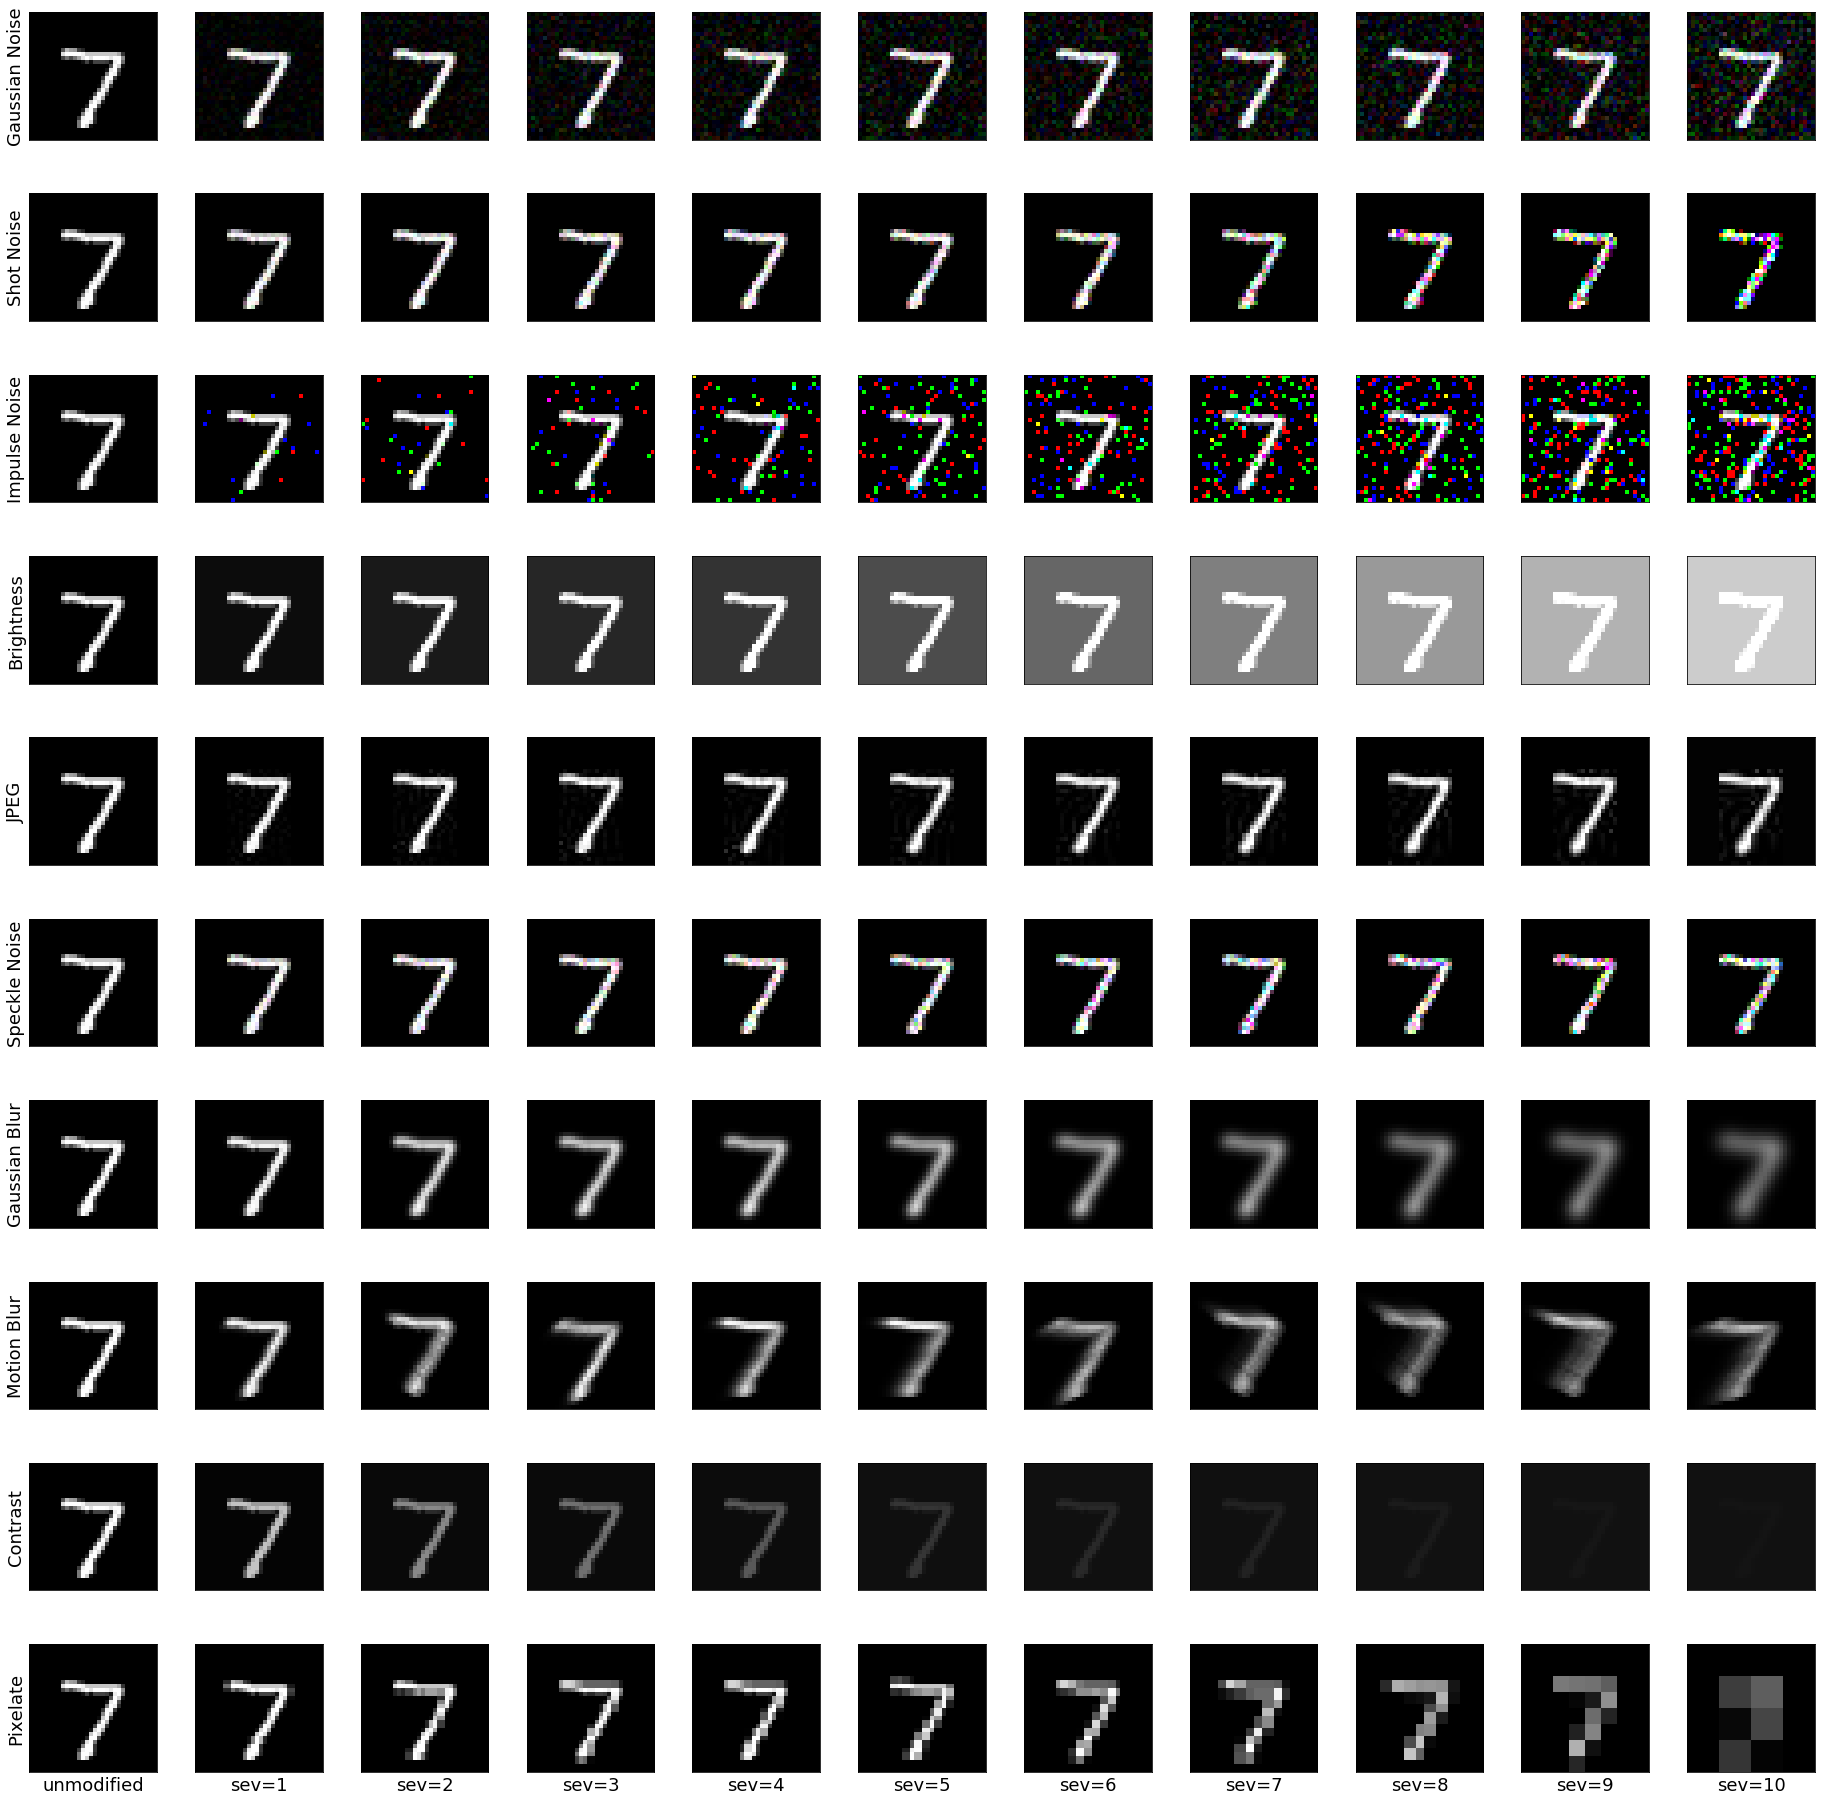

<Figure size 432x288 with 0 Axes>

In [78]:
#MNIST CELL

distribution_shifts = ["gaussian_noise",
"shot_noise",
"impulse_noise",
"brightness",
"jpeg_compression",
"speckle_noise",
"gaussian_blur",
    "motion_blur", "contrast", "pixelate"]

# distribution_shifts = ["motion_blur", "contrast", "pixelate"]

shift_name = {
"gaussian_noise" : 'Gaussian Noise',
"shot_noise" : 'Shot Noise',
"impulse_noise": 'Impulse Noise',
"defocus_blur": 'Defocus Blur',
"glass_blur" : 'Glass Blur',
"motion_blur": 'Motion Blur',
"zoom_blur": 'Zoom Blur',
"snow" : 'Snow',
"fog" : 'Fog',
"brightness" : 'Brightness',
"contrast" : 'Contrast',
"elastic_transform" : 'Elastic',
"pixelate" : 'Pixelate',
"jpeg_compression" : 'JPEG',
"speckle_noise" : 'Speckle Noise',
"gaussian_blur" : 'Gaussian Blur',
"spatter" : 'Spatter',
"saturate" : 'Saturate'}


# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False, 
#     )

dataset = 'mnist'

fig, axes = plt.subplots(nrows=len(distribution_shifts), ncols=11, figsize=(32, 32))

for i, shift in enumerate(distribution_shifts): 
    
    x = 0
    data_by_sev = load_dataset_sev(shift, dataset=dataset)

    for sev in data_by_sev.keys() : 
        
        data_s, labels_s = data_by_sev[sev]    
    #     print(f'label={labels[i]}, sev={sev[i]}')
        axes[i,x].set_xticks([], [])
        axes[i,x].set_yticks([], [])

        axes[i,x].imshow(data_s[0], cmap='gray')
#         axes[i,x].title.set_text(f'sev={sev}')
#         axes[i,x].set_title(f'sev={sev}', fontdict={'fontsize': 15, 'fontweight': 'medium'})
#         axes[x].set_fontsize(20)
        if x == 0: 
            axes[i,x].set_ylabel(shift_name[shift], fontsize=18)
        if i == len(distribution_shifts) -1: 
            if x == 0: 
                axes[i,x].set_xlabel('unmodified', fontsize=18)
            else: 
                axes[i,x].set_xlabel(f'sev={sev}', fontsize=18)
        x+=1
plt.subplots_adjust(left=None, bottom=.1, right=None, top=None, wspace=.3, hspace=.1)

plt.show()
plt.savefig(f'{dataset}_shifts.png')    



In [61]:
y_pred_test = model.predict(x_test)
y_pred_test_m = model.predict(x_test_m)

print(y_pred_test_m.shape)


(10000, 10)


In [62]:
acc_fn = keras.metrics.SparseCategoricalAccuracy()
print(f"svhn acc = {acc_fn(y_test, y_pred_test)}")
print(f"mnist acc = {acc_fn(y_test_m, y_pred_test_m)}")
ece = ExpectedCalibrationError()
print(f"svhn ece = {ece.call(y_test, y_pred_test)}")
print(f"mnist ece = {ece.call(y_test_m, y_pred_test_m)}")

svhn acc = 0.09000000357627869
mnist acc = 0.9149019718170166
svhn ece = 0.006544063333421946
mnist ece = 0.0007914838497526944


In [63]:
# print(y_pred_test[30:40])
# print(np.argmax(y_pred_test, axis=1)[30:40])

In [77]:
A=0
B=30
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})


def manual_obs_model(model, X_raw, X, Y): 
    correct = 0
    Y_hat = model.predict(X)
    for i in range(B - A): 
        print(f'y={Y[i]}, y_hat={np.argmax(Y_hat[i])}, probs={tf.nn.softmax(Y_hat[i]).numpy()}')
        plt.imshow(X_raw[i])
        plt.show()
#     acc = tf.reduce_sum(Y_hat == Y) / X.shape[0] 
#     print('acc = {acc}')


(200, 1024)
y=[5], y_hat=4, probs=[0.000 0.000 0.000 0.000 0.978 0.000 0.000 0.000 0.000 0.022]


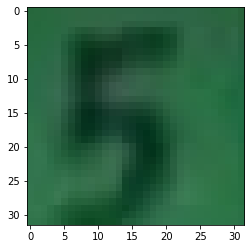

y=[2], y_hat=4, probs=[0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.001]


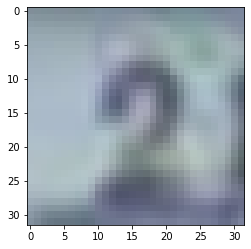

y=[1], y_hat=4, probs=[0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.001]


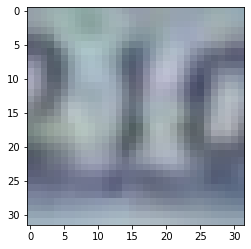

y=[10], y_hat=4, probs=[0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000]


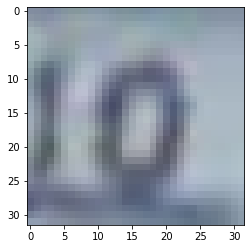

y=[6], y_hat=4, probs=[0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000]


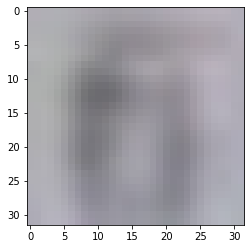

y=[1], y_hat=9, probs=[0.000 0.000 0.000 0.000 0.019 0.008 0.002 0.000 0.000 0.972]


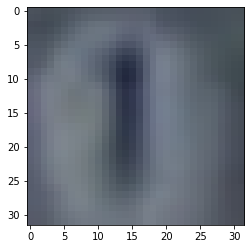

y=[9], y_hat=8, probs=[0.099 0.096 0.094 0.103 0.094 0.097 0.093 0.091 0.129 0.103]


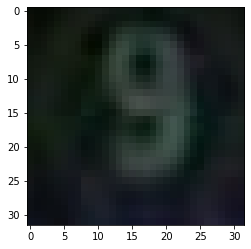

y=[1], y_hat=8, probs=[0.010 0.017 0.017 0.012 0.001 0.074 0.077 0.000 0.778 0.015]


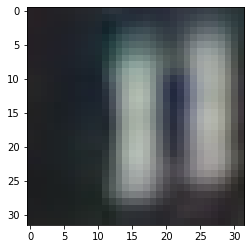

y=[1], y_hat=9, probs=[0.000 0.000 0.000 0.000 0.034 0.007 0.000 0.000 0.000 0.958]


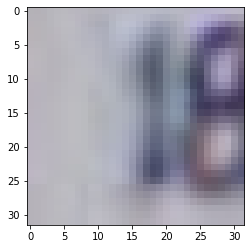

y=[8], y_hat=4, probs=[0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000]


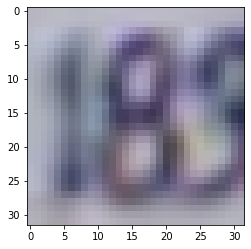

y=[3], y_hat=4, probs=[0.000 0.000 0.000 0.000 0.729 0.003 0.000 0.000 0.000 0.268]


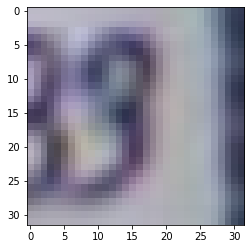

y=[6], y_hat=8, probs=[0.104 0.027 0.067 0.173 0.081 0.040 0.085 0.039 0.225 0.160]


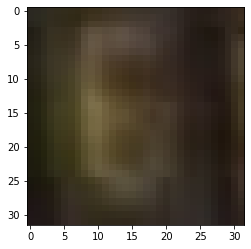

y=[5], y_hat=8, probs=[0.094 0.048 0.068 0.119 0.062 0.051 0.066 0.044 0.304 0.144]


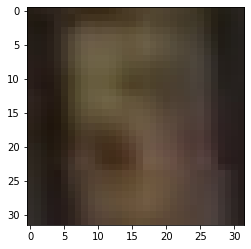

y=[1], y_hat=4, probs=[0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000]


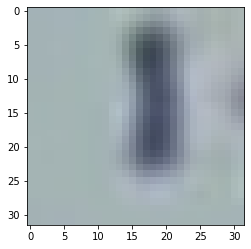

y=[4], y_hat=4, probs=[0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000]


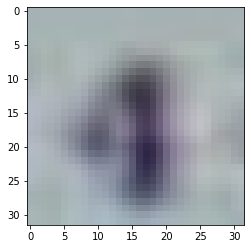

y=[4], y_hat=4, probs=[0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000]


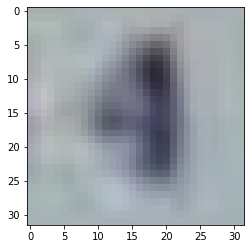

y=[1], y_hat=4, probs=[0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000]


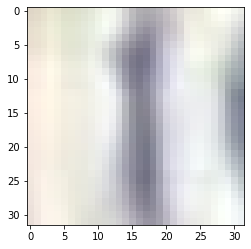

y=[6], y_hat=4, probs=[0.000 0.000 0.000 0.000 0.962 0.000 0.000 0.000 0.000 0.038]


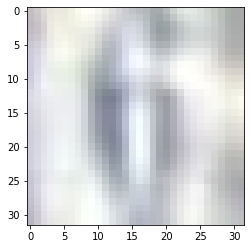

y=[3], y_hat=4, probs=[0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000]


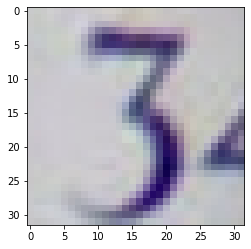

y=[4], y_hat=4, probs=[0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000]


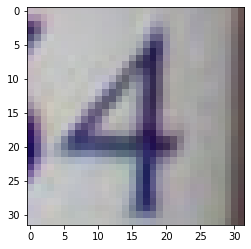

y=[2], y_hat=8, probs=[0.001 0.000 0.000 0.050 0.000 0.056 0.000 0.000 0.821 0.073]


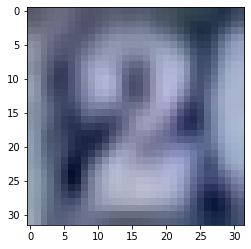

y=[10], y_hat=8, probs=[0.000 0.001 0.001 0.000 0.327 0.000 0.006 0.000 0.659 0.004]


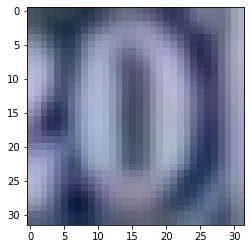

y=[1], y_hat=4, probs=[0.000 0.000 0.000 0.000 0.794 0.001 0.000 0.000 0.000 0.206]


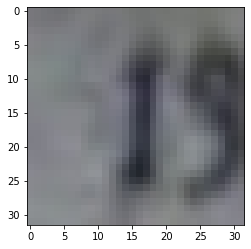

y=[3], y_hat=4, probs=[0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000]


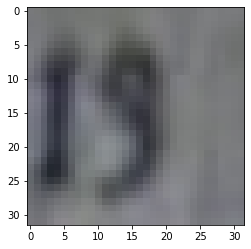

y=[2], y_hat=4, probs=[0.000 0.000 0.000 0.000 0.899 0.000 0.000 0.000 0.101 0.000]


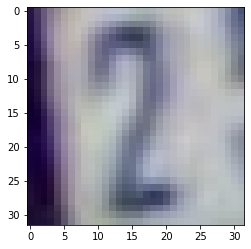

y=[5], y_hat=9, probs=[0.000 0.000 0.000 0.007 0.000 0.115 0.000 0.004 0.000 0.874]


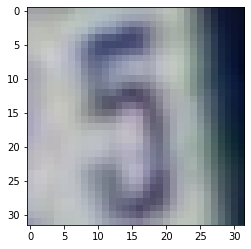

y=[4], y_hat=3, probs=[0.081 0.017 0.077 0.222 0.127 0.043 0.091 0.039 0.147 0.156]


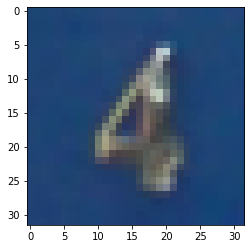

y=[1], y_hat=3, probs=[0.082 0.005 0.041 0.270 0.066 0.014 0.070 0.013 0.256 0.183]


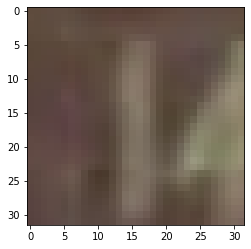

y=[4], y_hat=3, probs=[0.042 0.003 0.055 0.346 0.147 0.019 0.059 0.016 0.128 0.184]


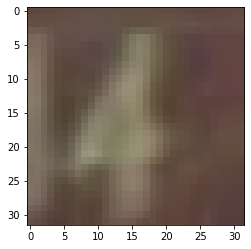

y=[2], y_hat=9, probs=[0.000 0.000 0.049 0.100 0.130 0.058 0.001 0.008 0.001 0.654]


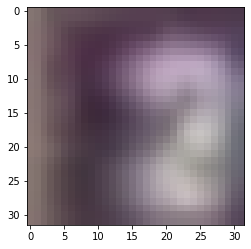

In [78]:
print(x_test.shape)
manual_obs_model(model, x_test_raw[A:B], x_test[A:B], y_test[A:B])

y=7, y_hat=7, probs=[0.000 0.000 0.001 0.000 0.000 0.000 0.000 0.999 0.000 0.000]


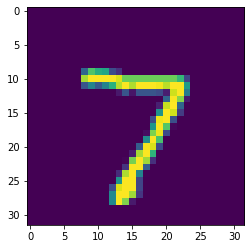

y=2, y_hat=2, probs=[0.000 0.002 0.967 0.028 0.000 0.001 0.000 0.000 0.001 0.000]


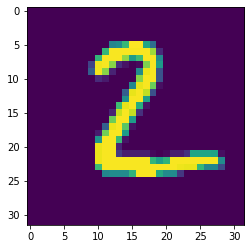

y=1, y_hat=1, probs=[0.000 0.995 0.000 0.000 0.000 0.000 0.000 0.005 0.000 0.000]


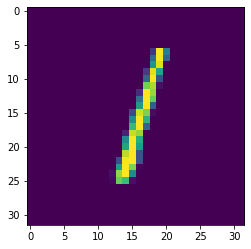

y=0, y_hat=0, probs=[1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]


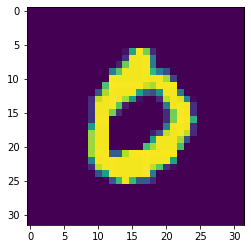

y=4, y_hat=4, probs=[0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.001]


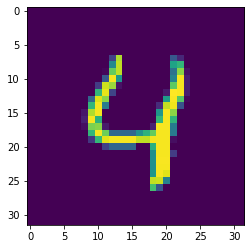

y=1, y_hat=1, probs=[0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]


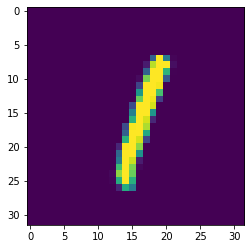

y=4, y_hat=4, probs=[0.000 0.000 0.012 0.000 0.974 0.001 0.001 0.000 0.001 0.010]


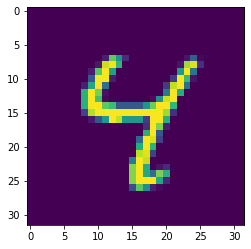

y=9, y_hat=9, probs=[0.000 0.000 0.000 0.001 0.007 0.000 0.000 0.003 0.000 0.990]


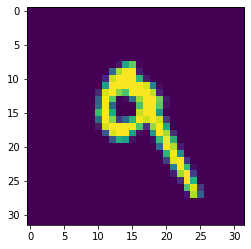

y=5, y_hat=5, probs=[0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000]


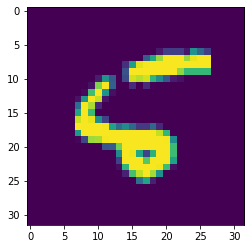

y=9, y_hat=9, probs=[0.000 0.000 0.000 0.000 0.002 0.000 0.000 0.000 0.000 0.997]


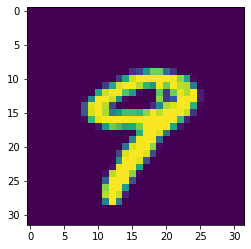

y=0, y_hat=0, probs=[1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]


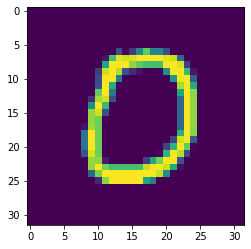

y=6, y_hat=6, probs=[0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000]


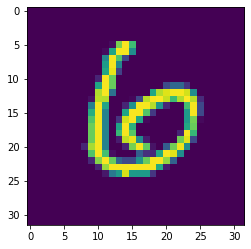

y=9, y_hat=9, probs=[0.000 0.000 0.000 0.000 0.001 0.000 0.000 0.000 0.000 0.999]


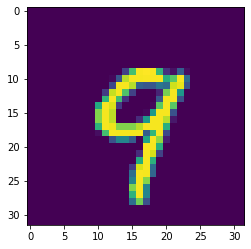

y=0, y_hat=0, probs=[1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]


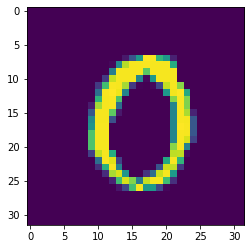

y=1, y_hat=1, probs=[0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]


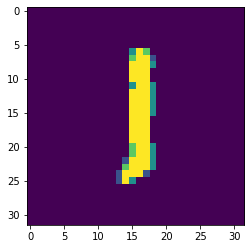

y=5, y_hat=5, probs=[0.000 0.000 0.000 0.003 0.000 0.967 0.000 0.000 0.000 0.030]


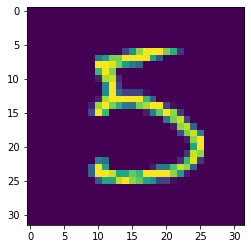

y=9, y_hat=9, probs=[0.000 0.000 0.000 0.000 0.001 0.000 0.000 0.000 0.000 0.999]


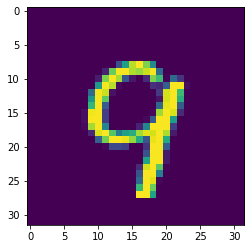

y=7, y_hat=7, probs=[0.000 0.000 0.002 0.000 0.000 0.000 0.000 0.998 0.000 0.000]


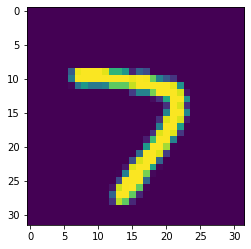

y=3, y_hat=5, probs=[0.000 0.000 0.000 0.000 0.005 0.958 0.000 0.000 0.036 0.000]


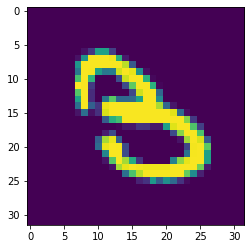

y=4, y_hat=4, probs=[0.000 0.000 0.000 0.000 0.998 0.000 0.000 0.001 0.000 0.002]


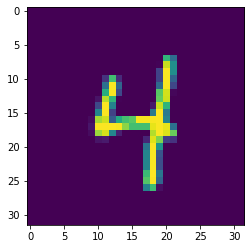

y=9, y_hat=9, probs=[0.000 0.005 0.000 0.000 0.014 0.000 0.000 0.010 0.000 0.971]


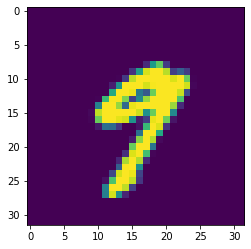

y=6, y_hat=6, probs=[0.000 0.000 0.000 0.000 0.000 0.002 0.998 0.000 0.000 0.000]


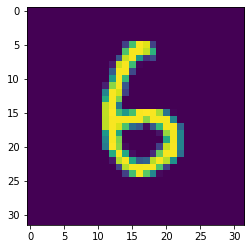

y=6, y_hat=6, probs=[0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000]


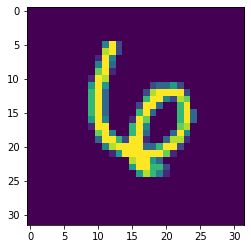

y=5, y_hat=5, probs=[0.000 0.000 0.000 0.000 0.000 0.552 0.000 0.000 0.000 0.448]


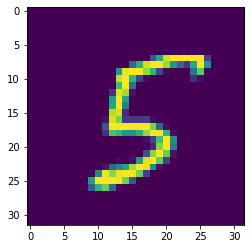

y=4, y_hat=4, probs=[0.000 0.000 0.000 0.000 0.994 0.000 0.000 0.002 0.000 0.005]


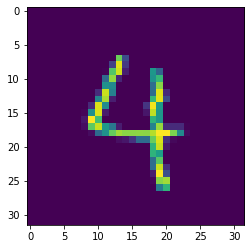

y=0, y_hat=0, probs=[1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]


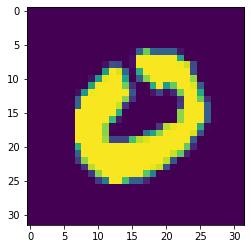

y=7, y_hat=7, probs=[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.999 0.000 0.000]


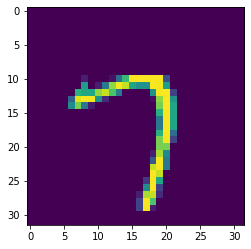

y=4, y_hat=4, probs=[0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.001]


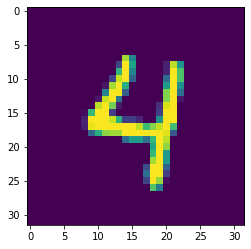

y=0, y_hat=0, probs=[1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]


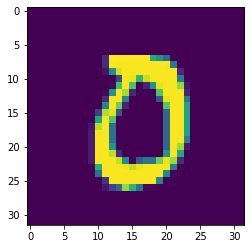

y=1, y_hat=1, probs=[0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]


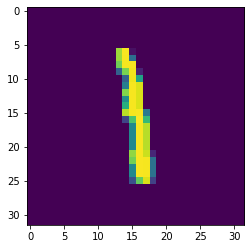

In [81]:
manual_obs_model(model, x_test_raw_m[A:B], x_test_m[A:B], y_test_m[A:B])

NameError: name 'd' is not defined